In [1]:
import pandas

talk from Sergei about project? cuz all video is none

ask about all current narabotki Sergei

- super-shortterm 6-21 час прогноза (time-gentime)
- shortterm 12-87
- longterm 81-234

они так разложены у нас в таблицах, я думаю проще будет на этапе препроцессинга их почистить. как и говорил раньше, если там незначительные численные различия в данных при groupby, то можно брать любое значение. если сильно различается, значит что-то пошло не так при склейке, пишите, будем разбираться

In [2]:
def prepare_data(df, need_kelvin_tranform=False):
    df = df.drop(columns=['time', 'fact_latitude', 'fact_longitude'])
    df['ecmwf_2d_gentime'] = pandas.to_datetime(df['ecmwf_2d_gentime'], unit='s')
    df['ecmwf_2d_time'] = pandas.to_datetime(df['ecmwf_2d_time'], unit='s')
    if "ecmwf" in df.columns:
        df = df.rename(columns={"ecmwf": "ecmwf_temp"})
    if "fact_temperature" in df.columns:
        df = df.rename(columns={"fact_temperature": "temperature"})
    if "fact_station_id" in df.columns:
        df = df.rename(columns={"fact_station_id": "station_id"})
    if need_kelvin_tranform:
        df['ecmwf_temp'] -= 273.15
    return df

def remove_duplicates(df):
    return df.groupby(['station_id', 'ecmwf_2d_time']).first().reset_index()


def read_and_prepare_data(filename, need_kelvin_tranform=False):
    data = pandas.read_csv(filename, sep='\t')
    print('Raw data readed')
    print(data.head())
    data = prepare_data(data, need_kelvin_tranform=need_kelvin_tranform)
    print('Data after prepare')
    print(data.head())
    data = remove_duplicates(data)
    print('Data after removing duplicates')
    print(data.head())
    return data

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
from sklearn.metrics import mean_squared_error

# усреднить по станциям и по времени и получить по два значения метрики на каждый из месяцев
def plot_averaged_by_station_and_period(data):
    print('Plotting averaged_by_station_and_period')
    grouped_data = data.groupby(['ecmwf_2d_gentime'])
    res = grouped_data.apply(lambda x: mean_squared_error(x['temperature'], x['ecmwf_temp'], squared=False))
    
    plt.figure(figsize=(7, 3.5))
    plt.title('rmse by periods between all stations')

    plt.plot([i for i in range(len(res.index))], [res[i] for i in res.index], color='lime')
    plt.xticks([i for i in range(len(res.index))], [i for i in res.index], rotation=80)

    plt.xlabel('period')
    plt.ylabel('rmse')
    plt.show()
    

In [5]:
# усреднить только по станциям для 1 января и 1 июля и построить значение метрики для каждого из 10 предсказанных дней
def plot_averaged_by_station(data, gen_date):
    print(f'Plotting averaged_by_station_and_period {gen_date}')
    data = data[data['ecmwf_2d_gentime'] == gen_date]
    data['day'] = data['ecmwf_2d_time'].dt.day
    
    points = data.groupby(['day']).apply(lambda x: mean_squared_error(x['temperature'], x['ecmwf_temp'], squared=False))
    days = set(points.index)
    plt.figure(figsize=(7, 3.5))
    plt.title(f'rmse between all stations by day {gen_date}')

    plt.plot([i for i in days], [points[i] for i in days], 'ro', markersize=2)

    plt.xlabel('day')
    plt.ylabel('rmse')
    plt.show()

In [6]:
def process_file(filename, need_kelvin_tranform=False):
    data = read_and_prepare_data(filename, need_kelvin_tranform=need_kelvin_tranform)
    #data.to_csv(f'{filename[:-4]}_res.csv', index=False)
    plot_averaged_by_station_and_period(data)
    plot_averaged_by_station(data, pandas.to_datetime('2020-01-01', format='%Y-%m-%d', errors='ignore'))
    plot_averaged_by_station(data, pandas.to_datetime('2020-07-01', format='%Y-%m-%d', errors='ignore'))

Raw data readed
         time       ecmwf  ecmwf_2d_gentime  ecmwf_2d_time  fact_latitude  \
0  1577862000  278.451538        1577836800     1577858400      36.210701   
1  1577862000  265.014038        1577836800     1577858400      38.426601   
2  1577862000  286.420288        1577836800     1577858400      34.120300   
3  1577862000  266.420288        1577836800     1577858400      47.793301   
4  1577862000  281.639038        1577836800     1577858400      66.017000   

   fact_longitude  fact_station_id  fact_temperature  
0     -115.194000            20589               4.0  
1     -113.012001            19551              -7.0  
2     -119.121002            19738              14.0  
3       13.004300            22107              -5.0  
4        8.083000            70298               7.0  
Data after prepare
   ecmwf_temp ecmwf_2d_gentime       ecmwf_2d_time  station_id  temperature
0    5.301538       2020-01-01 2020-01-01 06:00:00       20589          4.0
1   -8.135962       

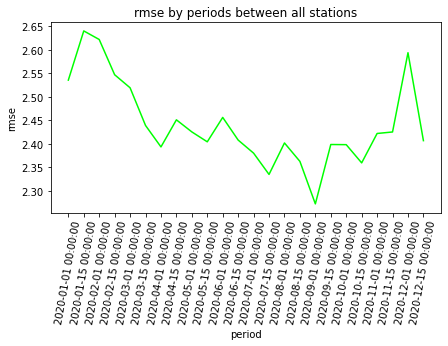

Plotting averaged_by_station_and_period 2020-01-01 00:00:00


/tmp/ipykernel_24281/2719217299.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day'] = data['ecmwf_2d_time'].dt.day


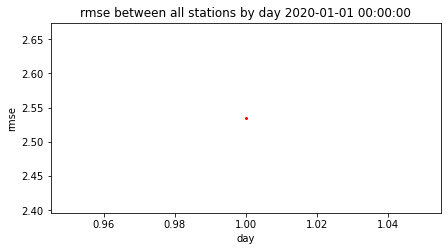

/tmp/ipykernel_24281/2719217299.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day'] = data['ecmwf_2d_time'].dt.day


Plotting averaged_by_station_and_period 2020-07-01 00:00:00


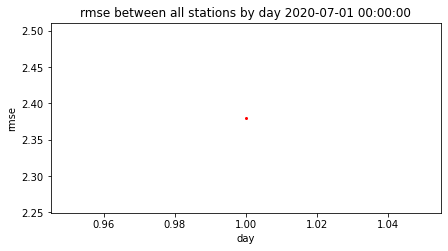

In [7]:
process_file('ecmwf_for_LAMBDA_super_shortterm.tsv', need_kelvin_tranform=True)

Raw data readed
         time  ecmwf_2d_gentime  ecmwf_2d_time  ecmwf_temp  fact_latitude  \
0  1578085200        1577836800     1578085200    16.50210      37.940201   
1  1578085200        1577836800     1578085200    23.68960      10.603117   
2  1578085200        1577836800     1578085200   -23.31040      62.266667   
3  1578085200        1577836800     1578085200   -16.24790      52.804167   
4  1578085200        1577836800     1578085200    20.15835      30.558399   

   fact_longitude  fact_temperature  station_id  
0      -75.466400              13.0       20641  
1      -66.990585              29.0       32280  
2      116.150000             -28.0       -9999  
3       93.240278             -13.0       -9999  
4      -92.099403              17.0       19856  
Data after prepare
  ecmwf_2d_gentime       ecmwf_2d_time  ecmwf_temp  temperature  station_id
0       2020-01-01 2020-01-03 21:00:00    16.50210         13.0       20641
1       2020-01-01 2020-01-03 21:00:00    23.68960

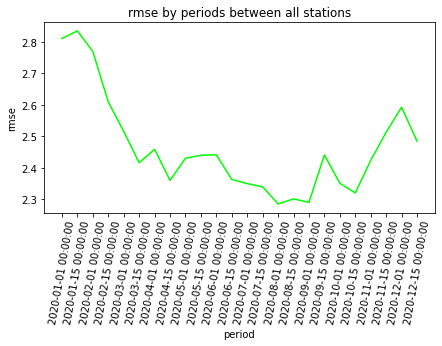

Plotting averaged_by_station_and_period 2020-01-01 00:00:00


/tmp/ipykernel_24281/2719217299.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day'] = data['ecmwf_2d_time'].dt.day


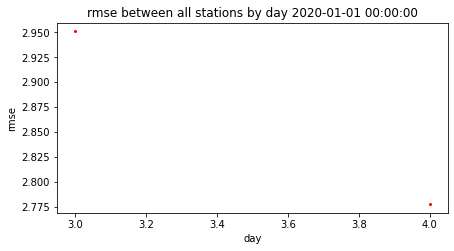

Plotting averaged_by_station_and_period 2020-07-01 00:00:00


/tmp/ipykernel_24281/2719217299.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day'] = data['ecmwf_2d_time'].dt.day


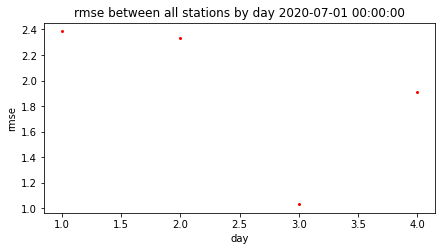

In [8]:
process_file('ecmwf_for_lambda_shortterm.tsv', need_kelvin_tranform=False)

Raw data readed
         time       ecmwf  ecmwf_2d_gentime  ecmwf_2d_time  fact_latitude  \
0  1578128400  271.789276        1577836800     1578128400      65.466667   
1  1578128400  297.633026        1577836800     1578128400       6.466667   
2  1578128400  275.789276        1577836800     1578128400      49.573611   
3  1578128400  305.758026        1577836800     1578128400     -25.920799   
4  1578128400  277.351776        1577836800     1578128400      43.866667   

   fact_longitude  fact_station_id  fact_temperature  
0       39.733333            49330              -2.0  
1        7.550000            38755              24.0  
2       15.080556            47399               1.0  
3       32.572601            15192              33.0  
4       18.433333            47297              -3.0  
Data after prepare
   ecmwf_temp ecmwf_2d_gentime       ecmwf_2d_time  station_id  temperature
0   -1.360724       2020-01-01 2020-01-04 09:00:00       49330         -2.0
1   24.483026       

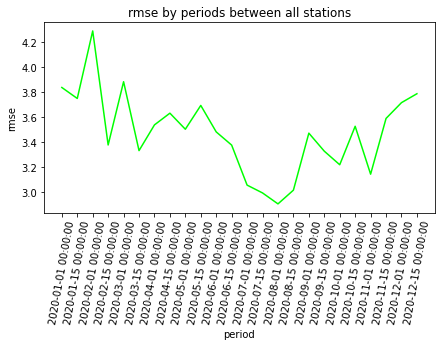

Plotting averaged_by_station_and_period 2020-01-01 00:00:00


/tmp/ipykernel_24281/2719217299.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day'] = data['ecmwf_2d_time'].dt.day


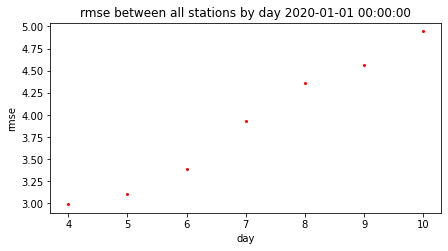

Plotting averaged_by_station_and_period 2020-07-01 00:00:00


/tmp/ipykernel_24281/2719217299.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day'] = data['ecmwf_2d_time'].dt.day


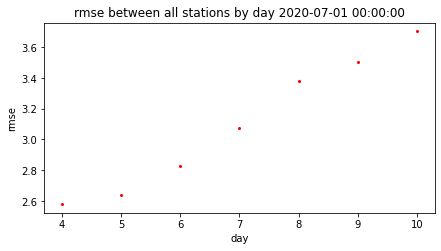

In [10]:
process_file('ecmwf_for_LAMBDA_longterm.tsv', need_kelvin_tranform=True)